In [1]:
%load_ext autoreload
%autoreload 2

# Building and Training a Learner

**Author:** [kkahloots](https://www.linkedin.com/in/kkahloots/)<br>
**Date created:** 2020/11/07<br>
**Last modified:** 2020/11/07<br>
**Description:** Performing learning as tasks by multiple learners.

## Introduction

This example shows how to do image classification from scratch, starting from JPEG
image files on disk, without leveraging pre-trained weights or a pre-made Keras
Application model. We demonstrate the workflow on the Kaggle Cats vs Dogs binary
 classification dataset.

We use the `image_dataset_from_directory` utility to generate the datasets, and
we use Keras image preprocessing layers for image standardization and data augmentation.


## Setup


In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.1


## Generate a `Dataset`


In [3]:
image_size = (180, 180, 3)
batch_size = 36
validation_percentage=0.3
valid_format = 'jpg'
image_dir = "data/PetImages/train"
holdout_dir = 'data/PetImages/holdout'

In [4]:
from generators.from_images.file_image_generator import make_image_lists, get_generators

In [5]:
imgs_list = make_image_lists(
    image_dir=image_dir, 
    validation_pct=validation_percentage, 
    valid_imgae_formats=valid_format
)

  DEBUG    | Looking for images in 'Cat'
  INFO     | 10573 file found
  DEBUG    | Looking for images in 'Dog'
  INFO     | 10506 file found


In [6]:
holdout_list = make_image_lists(
    image_dir=holdout_dir, 
    validation_pct=0.0, 
    valid_imgae_formats=valid_format
)

  DEBUG    | Looking for images in 'Cat'
  INFO     | 1175 file found
  DEBUG    | Looking for images in 'Dog'
  INFO     | 1168 file found


In [7]:
train_generator, validation_generator, holdout_generator = get_generators(
                                                                            images_list=imgs_list, 
                                                                            image_dir=image_dir,
                                                                            holdout_dir=holdout_dir,
                                                                            holdout_list=holdout_list,
                                                                            image_size=image_size, 
                                                                            batch_size=batch_size, 
                                                                            class_mode='binary',
                                                                            rotation_range=40,
                                                                            width_shift_range=0.2,
                                                                            height_shift_range=0.2,
                                                                            shear_range=0.2,
                                                                            zoom_range=0.2,
                                                                            horizontal_flip=True,
                                                                            fill_mode='nearest'
                                                                    )

  INFO     | Found 21009 training files


  INFO     | Found 70 validation files
  INFO     | Found 2343 training files


In [8]:
train_ds = tf.data.Dataset.from_generator(
    lambda: train_generator, 
    output_types= (tf.float32, tf.float32)
)

val_ds = tf.data.Dataset.from_generator(
    lambda: validation_generator, 
    output_types= (tf.float32, tf.float32)
)

holdout_ds = tf.data.Dataset.from_generator(
    lambda: holdout_generator, 
    output_types= (tf.float32, tf.float32)
)

In [9]:
# from dataset_generating import prepare_generators
# train_ds, val_ds, holdout_ds = prepare_generators(image_dir=image_dir, 
#                                                  batch_size=batch_size, 
#                                                  image_size=image_size,
#                                                  holdout_dir=holdout_dir)

## Build a model

We'll build a small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
 configuration, consider using
[Keras Tuner](https://github.com/keras-team/keras-tuner).

Note that:

- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.


In [10]:
from learner_building import make_learner

In [11]:
learner = make_learner(model_name='learner01', input_shape=image_size, num_classes=2)

Model: "learner01"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
dense (Dense)                (None, 180, 180, 100)     400       
_________________________________________________________________
dense_1 (Dense)              (None, 180, 180, 100)     10100     
_________________________________________________________________
dense_2 (Dense)              (None, 180, 180, 100)     10100     
_________________________________________________________________
dense_3 (Dense)              (None, 180, 180, 3)       303       
_________________________________________________________________
flatten (Flatten)            (None, 97200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 97

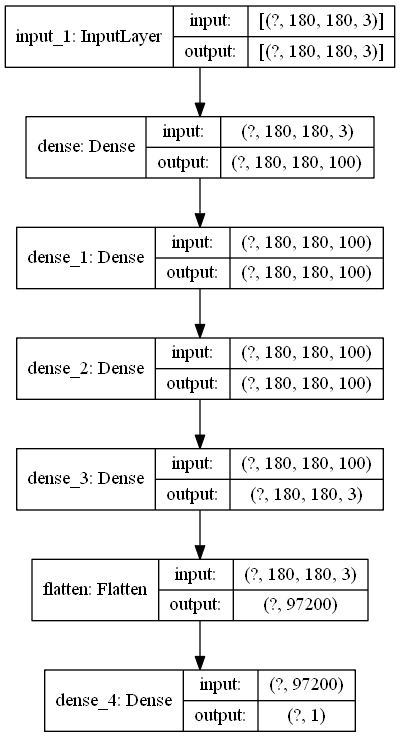

In [12]:
tf.keras.utils.plot_model(learner, show_shapes=True)

## Train the learner


In [13]:
from tensorflow_addons.optimizers import RectifiedAdam

In [14]:
es = tf.keras.callbacks.EarlyStopping(
    monitor='val-loss', 
    min_delta=1e-9, 
    patience=6, 
    verbose=1, 
    restore_best_weights=False
)

In [15]:
learner_sp = f"experiments/{learner.name}.hdf5"
ms =  tf.keras.callbacks.ModelCheckpoint(filepath=learner_sp, 
                                            verbose=1, 
                                            save_best_only=True)

In [16]:
from livelossplot import PlotLossesKeras

In [17]:
epochs = 10 #int(1e9)
loss_fn = tf.losses.binary_crossentropy
metrics=[tf.metrics.BinaryAccuracy()]

callbacks = [es, ms, PlotLossesKeras()]

learner.compile(
    optimizer=RectifiedAdam(),
    loss=loss_fn,
    metrics=metrics
)



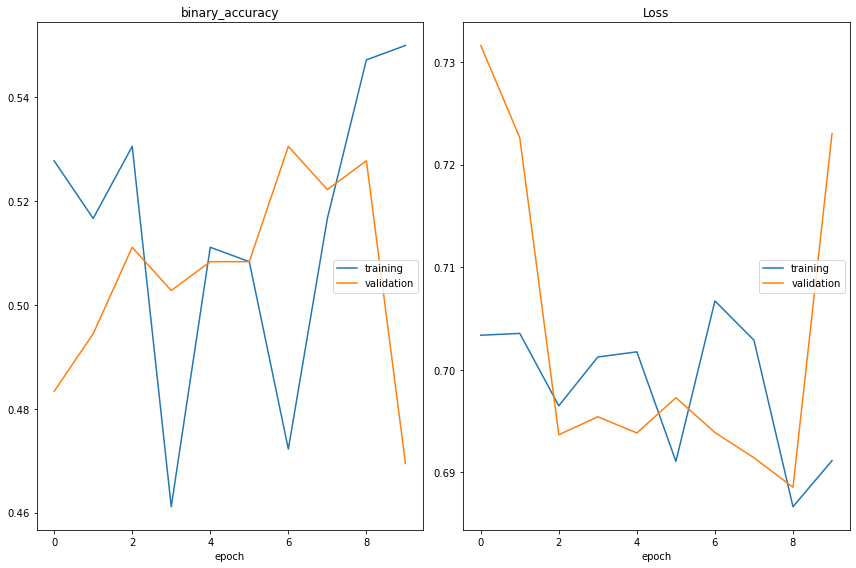

binary_accuracy
	training         	 (min:    0.461, max:    0.550, cur:    0.550)
	validation       	 (min:    0.469, max:    0.531, cur:    0.469)
Loss
	training         	 (min:    0.687, max:    0.707, cur:    0.691)
	validation       	 (min:    0.689, max:    0.732, cur:    0.723)
10/10 [==============================] - 10s 1s/step - loss: 0.6911 - binary_accuracy: 0.5500 - val_loss: 0.7230 - val_binary_accuracy: 0.4694


In [18]:
learner.fit(
    x=train_ds, 
    epochs=epochs, 
    steps_per_epoch=10,
    callbacks=callbacks, 
    validation_data=val_ds, 
    validation_steps=10,
    workers=-1,
    use_multiprocessing=True,
    verbose=1
)

In [19]:
del learner

## Evaluate the learner on training, validation and holdout dataset

Note that data augmentation and dropout are inactive at inference time.


In [20]:
learner = tf.keras.models.load_model(filepath=learner_sp, compile=False)

In [21]:
from tqdm import tqdm
import numpy as np

In [22]:
loss_fn = tf.losses.binary_crossentropy
metrics=[tf.metrics.Accuracy()]

callbacks = [es, ms, PlotLossesKeras()]

In [23]:
mertics_dict = dict(zip(list(map(lambda m: str(m.__class__.__name__), metrics)), metrics))

In [24]:
eval_epoch=10

In [25]:
def ds2itr(ds):
    while True:
        try:
            for data in ds:
                yield data
        except StopIteration as e:
            pass
        

In [26]:
ds = ds2itr(train_ds)
train_loss_scores = {}
train_loss_score = []
for ep in tqdm(range(eval_epoch)):
    batch = next(ds)
    train_loss_value = loss_fn(batch[1], learner.predict(batch[0]) )
    train_loss_score += [train_loss_value]
train_loss_scores = {loss_fn.__name__: train_loss_score}   

train_loss_scores = {k: {'min': 
                          tf.math.reduce_min([*val][0], axis=0).numpy(), 
                          'max':
                          tf.math.reduce_max([*val][0], axis=0).numpy(), 
                          'std': 
                          tf.math.reduce_std([*val][0], axis=0).numpy(), 
                          'mean': 
                          tf.math.reduce_mean([*val][0], axis=0).numpy() } for k, val in train_loss_scores.items()} 


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.06it/s]


In [27]:
ds = ds2itr(val_ds)
val_loss_scores = {}
val_loss_score = []
for ep in tqdm(range(eval_epoch)):
    batch = next(ds)
    val_loss_value = loss_fn(batch[1], learner.predict(batch[0]) )
    val_loss_score += [val_loss_value]
val_loss_scores = {loss_fn.__name__: val_loss_score}   

val_loss_scores = {k: {'min': 
                          tf.math.reduce_min([*val][0], axis=0).numpy(), 
                          'max':
                          tf.math.reduce_max([*val][0], axis=0).numpy(), 
                          'std': 
                          tf.math.reduce_std([*val][0], axis=0).numpy(), 
                          'mean': 
                          tf.math.reduce_mean([*val][0], axis=0).numpy() } for k, val in val_loss_scores.items()} 


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.17it/s]


In [28]:
ds = ds2itr(holdout_ds)
holdout_loss_scores = {}
holdout_loss_score = []
for ep in tqdm(range(eval_epoch)):
    batch = next(ds)
    holdout_loss_value = loss_fn(batch[1], learner.predict(batch[0]) )
    holdout_loss_score += [holdout_loss_value]
holdout_loss_scores = {loss_fn.__name__: holdout_loss_score}   

holdout_loss_scores = {k: {'min': 
                          tf.math.reduce_min([*val][0], axis=0).numpy(), 
                          'max':
                          tf.math.reduce_max([*val][0], axis=0).numpy(), 
                          'std': 
                          tf.math.reduce_std([*val][0], axis=0).numpy(), 
                          'mean': 
                          tf.math.reduce_mean([*val][0], axis=0).numpy() } for k, val in holdout_loss_scores.items()} 


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.16it/s]


In [29]:
print('train loss', train_loss_scores)
print('val loss',val_loss_scores)
print('holdout loss', holdout_loss_scores)

train loss {'binary_crossentropy': {'min': 0.69667345, 'max': 0.7874528, 'std': 0.019905705, 'mean': 0.7137842}}
val loss {'binary_crossentropy': {'min': 0.6934253, 'max': 0.71819687, 'std': 0.0057614446, 'mean': 0.7005062}}
holdout loss {'binary_crossentropy': {'min': 0.6543969, 'max': 0.73748493, 'std': 0.013555603, 'mean': 0.6703723}}


In [30]:
decision = lambda x: 1 if x > 0.5 else 0

In [31]:
ds = ds2itr(train_ds)
mertics_score = {}
for metric, metric_fn in mertics_dict.items():
    train_metric_scores = {}
    train_metric_score = []
    for ep in tqdm(range(eval_epoch)):
        batch = next(ds)
        pred = np.array([[decision(p)] for p in learner.predict(batch[0])])
        train_metric_value = metric_fn(batch[1], pred)
        train_metric_score += [train_metric_value]
    train_metric_scores = {metric: train_metric_score}   

    train_metric_scores = {k: {'min': 
                              tf.math.reduce_min([*val], axis=0).numpy(), 
                              'max':
                              tf.math.reduce_max([*val], axis=0).numpy(), 
                              'std': 
                              tf.math.reduce_std([*val], axis=0).numpy(), 
                              'mean': 
                              tf.math.reduce_mean([*val], axis=0).numpy() } for k, val in train_metric_scores.items()} 
   
    mertics_score.update(train_metric_scores)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.07it/s]


In [32]:
ds = ds2itr(val_ds)
mertics_score = {}
for metric, metric_fn in mertics_dict.items():
    val_metric_scores = {}
    val_metric_score = []
    for ep in tqdm(range(eval_epoch)):
        batch = next(ds)
        pred = np.array([[decision(p)] for p in learner.predict(batch[0])])
        val_metric_value = metric_fn(batch[1], pred)
        val_metric_score += [val_metric_value]
    val_metric_scores = {metric: val_metric_score}   

    val_metric_scores = {k: {'min': 
                              tf.math.reduce_min([*val], axis=0).numpy(), 
                              'max':
                              tf.math.reduce_max([*val], axis=0).numpy(), 
                              'std': 
                              tf.math.reduce_std([*val], axis=0).numpy(), 
                              'mean': 
                              tf.math.reduce_mean([*val], axis=0).numpy() } for k, val in val_metric_scores.items()} 
   
    mertics_score.update(val_metric_scores)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.14it/s]


In [33]:
ds = ds2itr(holdout_ds)
mertics_score = {}
for metric, metric_fn in mertics_dict.items():
    holdout_metric_scores = {}
    holdout_metric_score = []
    for ep in tqdm(range(eval_epoch)):
        batch = next(ds)
        pred = np.array([[decision(p)] for p in learner.predict(batch[0])])
        holdout_metric_value = metric_fn(batch[1], pred)
        holdout_metric_score += [holdout_metric_value]
    holdout_metric_scores = {metric: holdout_metric_score}   

    holdout_metric_scores = {k: {'min': 
                              tf.math.reduce_min([*val], axis=0).numpy(), 
                              'max':
                              tf.math.reduce_max([*val], axis=0).numpy(), 
                              'std': 
                              tf.math.reduce_std([*val], axis=0).numpy(), 
                              'mean': 
                              tf.math.reduce_mean([*val], axis=0).numpy() } for k, val in holdout_metric_scores.items()} 
   
    mertics_score.update(holdout_metric_scores)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.14it/s]


In [34]:
print('train metric', train_metric_scores)
print('val metric',val_metric_scores)
print('holdout metric', holdout_metric_scores)

train metric {'Accuracy': {'min': 0.5388889, 'max': 0.5833333, 'std': 0.013556513, 'mean': 0.56092584}}
val metric {'Accuracy': {'min': 0.5429293, 'max': 0.55864197, 'std': 0.004986143, 'mean': 0.5528705}}
holdout metric {'Accuracy': {'min': 0.54555553, 'max': 0.55176765, 'std': 0.0021638481, 'mean': 0.54823506}}


## Visualize the last layer

In [35]:
learner = tf.keras.models.load_model(filepath=learner_sp, compile=False)

In [36]:
learner.summary()

Model: "learner01"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
dense (Dense)                (None, 180, 180, 100)     400       
_________________________________________________________________
dense_1 (Dense)              (None, 180, 180, 100)     10100     
_________________________________________________________________
dense_2 (Dense)              (None, 180, 180, 100)     10100     
_________________________________________________________________
dense_3 (Dense)              (None, 180, 180, 3)       303       
_________________________________________________________________
flatten (Flatten)            (None, 97200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 97

In [37]:
learner.layers[-3]

In [38]:
image_size

(180, 180, 3)

In [59]:
x = tf.keras.layers.Reshape(image_size)(learner.layers[-3].output)

In [60]:
model2 = tf.keras.Model(inputs=learner.inputs, outputs=[x])
model2.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
dense (Dense)                (None, 180, 180, 100)     400       
_________________________________________________________________
dense_1 (Dense)              (None, 180, 180, 100)     10100     
_________________________________________________________________
dense_2 (Dense)              (None, 180, 180, 100)     10100     
_________________________________________________________________
dense_3 (Dense)              (None, 180, 180, 3)       303       
_________________________________________________________________
reshape_2 (Reshape)          (None, 180, 180, 3)       0         
Total params: 20,903
Trainable params: 20,903
Non-trainable params: 0
__________________________________________________

In [61]:
ds = ds2itr(val_ds)

In [62]:
import matplotlib.pyplot as plt
from PIL import Image

In [68]:
images = next(ds)[0]

In [69]:
images.shape

TensorShape([36, 180, 180, 3])

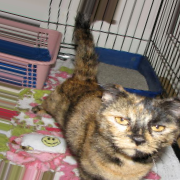

In [70]:
Image.fromarray((images[0].numpy()* 255.0).astype(np.uint8), mode='RGB')

In [71]:
predictions = model2.predict(images)

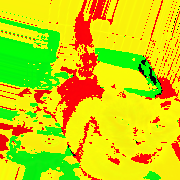

In [72]:
Image.fromarray((predictions[0] * 255.0).astype(np.uint8), mode='RGB')

In [85]:
from utils.reporting.ploting import plot_and_save_generated

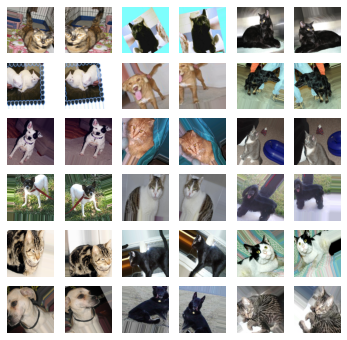

In [86]:
plot_and_save_generated(images.numpy(), epoch=999, path='.', gray=False, save=False)

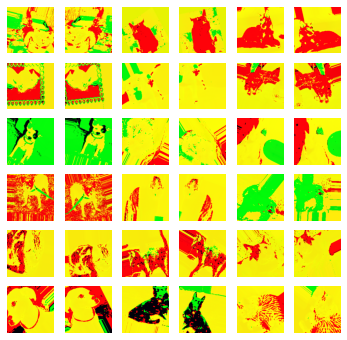

In [87]:
plot_and_save_generated( [Image.fromarray((img * 255.0).astype(np.uint8), mode='RGB') for img in predictions], epoch=999, path='.', gray=False, save=False)